In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import cupy as cp
import tensorflow as tf
import tensorflow_probability as tfp
import timeseriesanalysis as tsa
!pip install bezier
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
import itertools 
from scipy.special import comb
from scipy import signal

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.3 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.2.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
langchain

# **Kernel Function Computations For GPUs**

In [2]:
def remove_duplicate_arrays(array_list):
    """
    Removes duplicate NumPy arrays from a list, returning a new list
    containing only unique arrays.

    Args:
        array_list (list of numpy arrays): A list containing NumPy arrays.

    Returns:
        list of numpy arrays: A new list containing only the unique NumPy arrays
                              from the input list. The order of arrays in the
                              returned list is preserved from the original list
                              as much as possible (the *first* occurrence of each
                              unique array is kept).
    """

    unique_arrays = []
    seen = set()  # Use a set to track seen array's byte representations

    for arr in array_list:
        # Convert the array to bytes for efficient set comparison
        arr_bytes = arr.tobytes()

        if arr_bytes not in seen:
            unique_arrays.append(arr)
            seen.add(arr_bytes)

    return unique_arrays
    

def bezier_curve_fast_cupy(control_points, num_points=100):
    """
    Generates 2D Bézier curves for a batch of control point arrangements,
    optimized for speed using CuPy, and scales each curve so that its points sum to 1.

    Args:
        control_points (cupy array): A CuPy array of shape (num_arrangements, n+1, 2)
            representing the control points for each Bézier curve.
        num_points (int): The number of points to generate along each curve.

    Returns:
        cupy array: A CuPy array of shape (num_arrangements, num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curves, scaled to sum to 1.
    """

    n = control_points.shape[1] - 1
    num_arrangements = control_points.shape[0]

    # Precompute Bernstein basis polynomials for all t values
    t = cp.linspace(0, 1, num_points)[:, None]

    # Precompute the binomial coefficients (on the CPU, then transfer)
    binomial_coefficients = np.array([comb(n, i) for i in range(n + 1)])
    binomial_coefficients_gpu = cp.asarray(binomial_coefficients)

    # Vectorized calculation of Bernstein polynomials
    bernstein_polynomials = binomial_coefficients_gpu * (t ** cp.arange(n + 1).reshape(1, -1)) * ((1 - t) ** cp.arange(n, -1, -1).reshape(1, -1))

    # Calculate curve points using vectorized operations (Batch Matrix Multiplication)
    points = cp.matmul(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = cp.sum(points, axis=1, keepdims=True)
    mask = (curve_sum != 0)
    points = cp.where(mask, points / curve_sum, points)

    return points.astype(cp.float16)



def generate_coordinate_arrangements_cupy(point_ranges):
    """
    Generates all possible coordinate arrangements for a specified number of points,
    where each point can have its own independent x and y ranges.

    Args:
        point_ranges (list of tuples): A list of tuples, where each tuple represents the
            (x_range, y_range) for a single point.  Each x_range and y_range are themselves
            tuples specifying (min_x, max_x) and (min_y, max_y), respectively.

            For example:
            `point_ranges = [((0, 2), (0, 3)), ((1, 4), (2, 5)), ((0, 1), (1, 1))]`
            means:
                - Point 1: x can be 0, 1, or 2; y can be 0, 1, 2, or 3.
                - Point 2: x can be 1, 2, 3, or 4; y can be 2, 3, 4, or 5.
                - Point 3: x can be 0 or 1; y can only be 1.

    Returns:
        A CuPy array of shape (num_arrangements, num_points, 2).
    """
    arrangements = []
    num_points = len(point_ranges)

    def generate_recursive(current_arrangement, point_index):
        if point_index == num_points:
            arrangements.append(np.array(current_arrangement))
            return

        x_range, y_range = point_ranges[point_index]
        for x in range(x_range[0], x_range[1] + 1):
            for y in range(y_range[0], y_range[1] + 1):
                new_arrangement = current_arrangement + [[x, y]]
                generate_recursive(new_arrangement, point_index + 1)

    generate_recursive([], 0)
    return cp.asarray(arrangements)


# Example Usage:
# Define the individual x and y ranges for each point

min_x = 0
max_x = 4
min_y = 0
max_y = 7

point_ranges = [
    ((min_x, min_x), (min_y, max_y)),
    ((min_x, max_x), (min_y, max_y)),
    ((min_x, max_x), (min_y, max_y)),
    ((max_x, max_x), (min_y, max_y))  
]

# Generate all arrangements
all_arrangements_gpu = generate_coordinate_arrangements_cupy(point_ranges)

min_window_size = 10
max_window_size = 1000
window_size_step = 15
loop_points = range(min_window_size, max_window_size, window_size_step)
enum_loop_points = enumerate(loop_points)

# Preallocate the array to store the kernel functions (on the CPU)
kernel_functions = [] # Changed from np.empty to a list

with tqdm(desc="Processing") as pbar:
    for window_index, window_size in enum_loop_points:
        # Calculate all Bezier curves for the current window size in one go!
        all_curves = bezier_curve_fast_cupy(all_arrangements_gpu, num_points=window_size) #shape is num_arrangements, num_points, 2
        y_coords_gpu = all_curves[:, :, 1]  # Extract y-coordinates; shape is num_arrangements, num_points

        # Copy y-coordinates to CPU as a NumPy array
        y_coords_cpu = cp.asnumpy(y_coords_gpu)  #Shape is now num_arrangements, num_points

        #Store NumPy Array as a 2D array in the list.
        kernel_functions.append(y_coords_cpu) #Changed to append, not assign

        pbar.update(1)

# leave unique kernel functions only
for i in range(len(kernel_functions)):
    kernel_functions[i] = remove_duplicate_arrays(kernel_functions[i])

Processing: 66it [00:11,  5.59it/s]


# **Kernel Function Computations For TPUs**

In [ ]:
tfd = tfp.distributions

def bezier_curve_fast_tf(control_points, num_points=100):
    """
    Generates 2D Bézier curves for a batch of control point arrangements,
    optimized for speed using TensorFlow and TPUs, and scales each curve so that its points sum to 1.

    Args:
        control_points (tf.Tensor): A TensorFlow tensor of shape (num_arrangements, n+1, 2)
            representing the control points for each Bézier curve.
        num_points (int): The number of points to generate along each curve.

    Returns:
        tf.Tensor: A TensorFlow tensor of shape (num_arrangements, num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curves, scaled to sum to 1.
    """

    n = tf.cast(tf.shape(control_points)[1] - 1, dtype=tf.float32)  # Use tf.cast
    num_arrangements = tf.shape(control_points)[0]

    # Precompute Bernstein basis polynomials for all t values
    t = tf.linspace(0.0, 1.0, num_points)[:, None]

    # Precompute the binomial coefficients (on the CPU, then transfer if needed - usually XLA handles this fine)
    binomial_coefficients = np.array([comb(int(n), i) for i in range(int(n) + 1)])
    binomial_coefficients_tf = tf.constant(binomial_coefficients, dtype=tf.float32) # Convert to tf.constant

    # Vectorized calculation of Bernstein polynomials
    arange_n_plus_1 = tf.range(int(n + 1), dtype=tf.float32)
    bernstein_polynomials = binomial_coefficients_tf * (t ** arange_n_plus_1) * ((1 - t) ** tf.reverse(arange_n_plus_1, axis=[0]))

    # Calculate curve points using vectorized operations (Batch Matrix Multiplication)
    bernstein_polynomials = tf.cast(bernstein_polynomials, dtype=tf.float32)
    control_points = tf.cast(control_points, dtype=tf.float32)
    points = tf.matmul(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = tf.reduce_sum(points, axis=1, keepdims=True)
    mask = tf.not_equal(curve_sum, 0)
    points = tf.where(mask, points / curve_sum, points)

    return tf.cast(points, dtype=tf.float16)


def generate_coordinate_arrangements_tf():
    """
    Generates all possible coordinate arrangements for four points, as a TensorFlow tensor.

    Returns:
        A TensorFlow tensor of shape (num_arrangements, 4, 2).
    """
    arrangements = []
    for y1 in range(0, 7):
        for x2 in range(0, 5):
            for y2 in range(0, 7):
                for x3 in range(0, 5):
                    for y3 in range(0, 7):
                        for y4 in range(0, 7):
                            point1 = [0, y1]
                            point2 = [x2, y2]
                            point3 = [x3, y3]
                            point4 = [4, y4]
                            arrangements.append(np.array([point1, point2, point3, point4]))

    return tf.constant(np.array(arrangements), dtype=tf.float32)


# TPU Strategy Setup (REQUIRED if running on TPU)
# This part needs to be adjusted based on your specific TPU setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default strategy in case of no TPU

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Now, wrap everything that uses the TPU inside the strategy scope
with strategy.scope():
    # Generate all arrangements
    all_arrangements_tf = generate_coordinate_arrangements_tf()

    min_window_size = 10
    max_window_size = 1000
    window_size_step = 15
    loop_points = range(min_window_size, max_window_size, window_size_step)
    enum_loop_points = enumerate(loop_points)

    # Preallocate the array to store the kernel functions (on the CPU)
    kernel_functions = np.empty((len(loop_points), len(all_arrangements_tf)), dtype=object)


    with tqdm(desc="Processing") as pbar:
        for window_index, window_size in enum_loop_points:
            # Calculate all Bezier curves for the current window size in one go!
            all_curves = bezier_curve_fast_tf(all_arrangements_tf, num_points=window_size) #shape is num_arrangements, num_points, 2
            y_coords_tf = all_curves[:, :, 1]  # Extract y-coordinates; shape is num_arrangements, num_points

            # Convert y_coords_tf to NumPy array
            y_coords_np = y_coords_tf.numpy()

            # Store NumPy Array in 2d output.
            kernel_functions[window_index, :] = [y_coords_np[i, :] for i in range(y_coords_np.shape[0])]

            pbar.update(1)

print("Finished processing.")

# Computations for Multiscale LTI Filter Information

In [79]:
def conv_subtract_scale(time_series, kernel_functions):
    """
    Performs convolution, subtraction, and scaling operations efficiently, 
    minimizing data conversions.

    Args:
        time_series: A 1D NumPy array of time series data.
        kernel_functions: A 2D NumPy array of kernel functions.

    Returns:
        A TensorFlow tensor representing the result of the operations.
    """

    # 1. Preprocessing & Reshaping in NumPy (Optimize for TF Input)
    time_series = np.expand_dims(time_series, axis=(0, -1))  # (1, time_series_length, 1)
    kernel_functions = np.expand_dims(kernel_functions, axis=1)  # (num_kernel_functions, 1, kernel_length)
    kernel_functions = np.transpose(kernel_functions, (2, 1, 0))  # (kernel_length, 1, num_kernel_functions)


    # 2. Convert to TensorFlow tensors
    time_series_tf = tf.convert_to_tensor(time_series, dtype=tf.float16)
    kernel_functions_tf = tf.convert_to_tensor(kernel_functions, dtype=tf.float16)

    # 3. Convolution in TensorFlow
    convolved_tf = tf.nn.convolution(
        input=time_series_tf,
        filters=kernel_functions_tf,
        padding='VALID',
        strides=1,
    )
    convolved_tf = tf.squeeze(convolved_tf, axis=0)  # Remove batch dim

    # 4. Reshape time_series_tf for subtraction (all in TensorFlow)
    time_series_tf = tf.reshape(time_series_tf, [time_series_tf.shape[1]])  #Now remove the dims for the tf tensor
    starting_index = int(time_series_tf.shape[0] - convolved_tf.shape[0])
    time_series_sliced_tf = time_series_tf[starting_index:] #Slice now in TF

    # 5. Reshape for subtraction (all in TensorFlow)
    # Determine if convolved_tf needs to be reshaped based on time_series_sliced_tf's shape
    if time_series_sliced_tf.shape[0] == convolved_tf.shape[1]:
        time_series_reshaped_tf = tf.reshape(time_series_sliced_tf, [1, -1])
    elif time_series_sliced_tf.shape[0] == convolved_tf.shape[0]:
        time_series_reshaped_tf = tf.reshape(time_series_sliced_tf, [-1, 1])
    else:
        raise ValueError("Arrays are not compatible. time_series must match either the number of rows or columns of filter outputs.")
    
    # 6. Perform subtraction *directly in TensorFlow* (No CuPy conversion anymore!)
    intermediate_result = time_series_reshaped_tf - convolved_tf

    return intermediate_result

# Example Time Series
length = 5000
sample_rate = 10
time_series = tsa.symmetric_random_walk(length, sample_rate)
#print(len(kernel_functions[0]))
resid = conv_subtract_scale(time_series, kernel_functions[0])

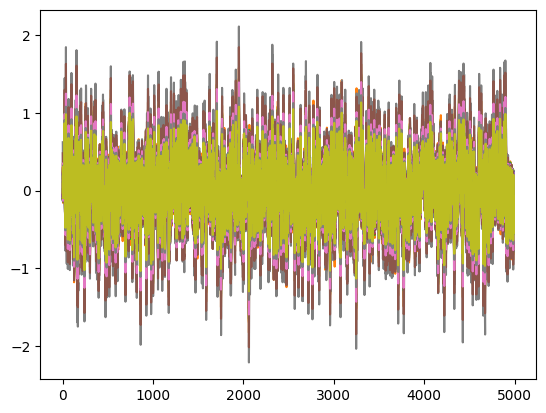

In [80]:
plt.plot(resid[:,1:50])

In [72]:
def conv_subtract_scale(time_series, kernel_functions):

    time_series = np.expand_dims(time_series, axis=(0, -1))  # Shape: (1, time_series_length, 1)
    kernel_functions = np.expand_dims(kernel_functions, axis=1)  # Shape: (num_kernel_functions, 1, kernel_length)
    kernel_functions = np.transpose(kernel_functions, (2, 1, 0))  # Shape: (kernel_length, 1, num_kernel_functions)

    time_series = tf.convert_to_tensor(time_series, dtype=tf.float16)
    kernel_functions = tf.convert_to_tensor(kernel_functions, dtype=tf.float16)

    # 2. Perform the convolution
    convolved = tf.nn.convolution(
        input=time_series,
        filters=kernel_functions,
        padding='VALID',
        strides=1,
    )

    # Remove the batch dimension
    convolved = tf.squeeze(convolved, axis=0)
    
    time_series = tf.reshape(time_series, [time_series.shape[1]])
    starting_index = int(len(time_series)-convolved.shape[0])
    print(len(time_series), convolved.shape[0])
    # Convert to CuPy arrays if necessary
    if isinstance(time_series[starting_index:], np.ndarray):
        time_series_gpu = cp.asarray(time_series[starting_index:])
    else:
        time_series_gpu = time_series[starting_index:]
    #print(tf.reshape(time_series_gpu, [time_series_gpu.shape[1]]).shape)
    #print(time_series_gpu.reshape(time_series_gpu.shape[1]).shape)
    if isinstance(convolved, np.ndarray):
        convolved_gpu = cp.asarray(convolved)
    else:
        convolved_gpu = convolved

    print(time_series_gpu.shape, convolved_gpu.shape)
    # Case 1: arr_2d is (m, n) - Original case
    if time_series_gpu.shape[0] == convolved_gpu.shape[1]:  # arr_1d is length n, arr_2d is (m, n)
        time_series_reshaped = time_series_gpu.reshape(1, -1)
        intermediate_result = time_series_reshaped - convolved_gpu  #Store result

    # Case 2: arr_2d is (n, m)
    
    elif time_series_gpu.shape[0] == convolved_gpu.shape[0]: # arr_1d is length n, arr_2d is (n, m)
        time_series_reshaped = time_series_gpu.reshape(-1, 1)  # Reshape to a column vector
        intermediate_result = time_series_reshaped - convolved_gpu  # Store result
        #intermediate_result = time_series_gpu - convolved_gpu

    #If not compatable, throw the error
    else:
      raise ValueError("Arrays are not compatible.  time_series must match either the number of rows or columns of filter outputs.")

    return intermediate_result

# Example Time Series
length = 5000
sample_rate = 10
time_series = tsa.symmetric_random_walk(length, sample_rate)
#print(len(kernel_functions[0]))
resid = conv_subtract_scale(time_series, kernel_functions[0])

5000 4991
(4991,) (4991, 3746)


AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
def apply_kernel_filters(time_series, kernel_functions, padding='VALID', strides=1):
    """
    Applies a set of kernel functions to a 1D time series using tf.nn.conv1d.

    Args:
        time_series: A 1D numpy array representing the time series data.
        kernel_functions: A 2D numpy array where each row is a kernel function.  Shape (num_kernel_functions, kernel_length).
        padding:  String, either 'VALID' or 'SAME'.  Determines how the edges are handled.
        strides: int or a list/tuple of ints.  Stride of the convolution.  If an int is provided, it is used for all spatial dimensions.  Defaults to 1.

    Returns:
        A tensor with shape [1, out_width, num_kernel_functions], where out_width
        depends on the padding and stride.  We'll typically squeeze this to
        [out_width, num_kernel_functions].
    """
    # 1. Prepare the data for tf.nn.convolution
    time_series = np.expand_dims(time_series, axis=(0, -1))  # Shape: (1, time_series_length, 1)
    kernel_functions = np.expand_dims(kernel_functions, axis=1) # Shape: (num_kernel_functions, 1, kernel_length)
    kernel_functions = np.transpose(kernel_functions, (2, 1, 0)) # Shape: (kernel_length, 1, num_kernel_functions)
    time_series = tf.convert_to_tensor(time_series, dtype=tf.float32)
    kernel_functions = tf.convert_to_tensor(kernel_functions, dtype=tf.float32)

    # 2. Perform the convolution
    convolved = tf.nn.convolution(
        input=time_series,
        filters=kernel_functions,
        padding=padding,
        strides=strides,
    )

    return convolved  # Shape: (1, out_width, num_kernel_functions)

# Example Usage
if __name__ == '__main__':
    # Example Time Series
    time_series_length = 3000
    time_series = tsa.generate_gaussian_random_walk(time_series_length, 10)

    # Example Kernel Functions
    num_kernel_functions = 5
    kernel_length = 10
    kernel_functions = np.random.rand(num_kernel_functions, kernel_length)

    # Normalize the kernels so they sum to 1 (important for linear time-invariant filtering)
    kernel_functions = kernel_functions / np.sum(kernel_functions, axis=1, keepdims=True)

    # Apply the convolution
    convolved_output = apply_kernel_filters(time_series, kernel_functions, padding='VALID', strides=1)

    # Print the shape of the output
    print("Shape of convolved output:", convolved_output.shape)

    # Remove the batch dimension if you like
    convolved_output = tf.squeeze(convolved_output, axis=0)
    print("Shape of convolved output after squeeze:", convolved_output.shape) # (91, 5) when padding is valid

    # You can now work with the convolved_output, which contains the filtered
    # time series for each kernel function. For instance, you could plot
    # the first filtered time series:
    #import matplotlib.pyplot as plt
    #plt.plot(convolved_output[:, 0].numpy()) # plot the first filter output
    #plt.show()

In [36]:
def convolve_time_series(time_series, kernel_functions):
    """
    Applies a set of kernel functions to a 1D time series using tf.nn.convolution
    with stride 1 and "VALID" padding.

    Args:
        time_series: A 1D numpy array representing the time series data.
        kernel_functions: A 2D numpy array where each row is a kernel function.
                         Shape: (num_kernel_functions, kernel_length).

    Returns:
        A TensorFlow tensor with shape [out_width, num_kernel_functions],
        where out_width = time_series_length - kernel_length + 1.
    """

    # 1. Prepare the data for tf.nn.convolution
    time_series = np.expand_dims(time_series, axis=(0, -1))  # Shape: (1, time_series_length, 1)
    kernel_functions = np.expand_dims(kernel_functions, axis=1)  # Shape: (num_kernel_functions, 1, kernel_length)
    kernel_functions = np.transpose(kernel_functions, (2, 1, 0))  # Shape: (kernel_length, 1, num_kernel_functions)

    time_series = tf.convert_to_tensor(time_series, dtype=tf.float16)
    kernel_functions = tf.convert_to_tensor(kernel_functions, dtype=tf.float16)

    # 2. Perform the convolution
    convolved = tf.nn.convolution(
        input=time_series,
        filters=kernel_functions,
        padding='VALID',
        strides=1,
    )

    # Remove the batch dimension
    convolved = tf.squeeze(convolved, axis=0)

    return convolved

# Example Usage
if __name__ == '__main__':
    # Example Time Series
    length = 5000
    sample_rate = 10
    time_series = tsa.symmetric_random_walk(length, sample_rate)

    # Apply the convolution
    convolved_output = convolve_time_series(time_series, kernel_functions[0])

    # Print the shape of the output
    print("Shape of convolved output:", convolved_output.shape)

Shape of convolved output: (4991, 3746)


Pairs of arrays with equal values (CuPy, TF): [(0, 3)]
Pairs of arrays with equal values (CuPy, no matches): []
Pairs of arrays with equal values (CuPy, NumPy and mixed): [(0, 2), (0, 3), (2, 3)]
Pairs of arrays with equal values (CuPy, lists): [(0, 2)]


In [35]:
def subtract_2d_from_1d(arr_1d, arr_2d):
    """
    Subtracts each row of a 2D array from a 1D array.

    Args:
        arr_1d: A 1D numpy array of length n.
        arr_2d: A 2D numpy array of shape (m, n).

    Returns:
        A 2D numpy array of shape (m, n) where each row is the result of
        subtracting the corresponding row of arr_2d from arr_1d.
    """

    # Ensure that the arrays have compatible shapes
    if arr_1d.shape[-1] != arr_2d.shape[-1]: # same as `arr_1d.shape[0] != arr_2d.shape[1]` since arr_1d has only one axis
        raise ValueError("Arrays must have the same length along the last dimension")

    # Reshape arr_1d to be a 2D array with shape (1, n) so that broadcasting works correctly
    arr_1d_reshaped = arr_1d.reshape(1, -1)

    # Subtract using broadcasting
    result = arr_1d_reshaped - arr_2d

    return result

# Example Usage
if __name__ == '__main__':
    n = 5
    m = 3
    arr_1d = np.array([10, 20, 30, 40, 50])
    arr_2d = np.array([[1, 2, 3, 4, 5],
                       [6, 7, 8, 9, 10],
                       [11, 12, 13, 14, 15]])

    result = subtract_2d_from_1d(arr_1d, arr_2d)
    print(result)

result = subtract_2d_from_1d(time_series[9:], convolved_output[:, 0:49])

[[ 9 18 27 36 45]
 [ 4 13 22 31 40]
 [-1  8 17 26 35]]


ValueError: Arrays must have the same length along the last dimension

In [ ]:
time_series[9:], convolved_output[:, 1:50]

In [4]:
def subtract_2d_from_1d_flexible(arr_1d, arr_2d):
    """
    Subtracts a 2D array from a 1D array, handling both (m, n) and (n, m) shapes.

    Args:
        arr_1d: A 1D numpy array of length n.
        arr_2d: A 2D numpy array of shape (m, n) OR (n, m).

    Returns:
        A 2D numpy array where each row/column of arr_2d is subtracted from arr_1d.
        The output shape depends on the input arr_2d shape.
    """

    # Case 1: arr_2d is (m, n) - Original case
    if arr_1d.shape[0] == arr_2d.shape[1]:  # arr_1d is length n, arr_2d is (m, n)
        arr_1d_reshaped = arr_1d.reshape(1, -1)
        result = arr_1d_reshaped - arr_2d
        return result

    # Case 2: arr_2d is (n, m)
    elif arr_1d.shape[0] == arr_2d.shape[0]: # arr_1d is length n, arr_2d is (n, m)
        arr_1d_reshaped = arr_1d.reshape(-1, 1)  # Reshape to a column vector
        result = arr_1d_reshaped - arr_2d
        return result

    #If not compatable, throw the error
    else:
      raise ValueError("Arrays are not compatible.  arr_1d must match either the number of rows or columns of arr_2d.")

# Example Usage:
arr_1d = np.array([1, 2, 3])
arr_2d_mn = np.array([[4, 5, 6], [7, 8, 9]])  # Shape (2, 3) - m x n
arr_2d_nm = np.array([[4, 7], [5, 8], [6, 9]])  # Shape (3, 2) - n x m

result_mn = subtract_2d_from_1d_flexible(arr_1d, arr_2d_mn)
print("Result (m, n):\n", result_mn)

result_nm = subtract_2d_from_1d_flexible(arr_1d, arr_2d_nm)
print("Result (n, m):\n", result_nm)

# Example that triggers the value error
arr_1d_err = np.array([1,2,3,4])
arr_2d_err = np.array([[4,7],[5,8],[6,9]])
result_error = subtract_2d_from_1d_flexible(arr_1d_err, arr_2d_err)
print(result_error)

Result (m, n):
 [[-3 -3 -3]
 [-6 -6 -6]]
Result (n, m):
 [[-3 -6]
 [-3 -6]
 [-3 -6]]


ValueError: Arrays are not compatible.  arr_1d must match either the number of rows or columns of arr_2d.

In [37]:
import cupy as cp
import numpy as np  # for generating test data

def subtract_2d_from_1d_flexible_cupy(arr_1d, arr_2d):
    """
    Subtracts a 2D array from a 1D array, handling both (m, n) and (n, m) shapes,
    with CuPy (GPU) acceleration.

    Args:
        arr_1d: A 1D NumPy or CuPy array of length n.
        arr_2d: A 2D NumPy or CuPy array of shape (m, n) OR (n, m).

    Returns:
        A 2D CuPy array where each row/column of arr_2d is subtracted from arr_1d.
        The output shape depends on the input arr_2d shape.
    """

    # Convert to CuPy arrays if necessary
    if isinstance(arr_1d, np.ndarray):
        arr_1d_gpu = cp.asarray(arr_1d)
    else:
        arr_1d_gpu = arr_1d

    if isinstance(arr_2d, np.ndarray):
        arr_2d_gpu = cp.asarray(arr_2d)
    else:
        arr_2d_gpu = arr_2d

    # Case 1: arr_2d is (m, n) - Original case
    if arr_1d_gpu.shape[0] == arr_2d_gpu.shape[1]:  # arr_1d is length n, arr_2d is (m, n)
        arr_1d_reshaped = arr_1d_gpu.reshape(1, -1)
        result = arr_1d_reshaped - arr_2d_gpu
        return result

    # Case 2: arr_2d is (n, m)
    elif arr_1d_gpu.shape[0] == arr_2d_gpu.shape[0]: # arr_1d is length n, arr_2d is (n, m)
        arr_1d_reshaped = arr_1d_gpu.reshape(-1, 1)  # Reshape to a column vector
        result = arr_1d_reshaped - arr_2d_gpu
        return result

    #If not compatable, throw the error
    else:
      raise ValueError("Arrays are not compatible.  arr_1d must match either the number of rows or columns of arr_2d.")


# Example Usage:
if __name__ == '__main__':
    # Example Data (on CPU)
    arr_1d_cpu = np.array([1, 2, 3], dtype=np.float32) #Important to set numpy to same datatypes as cupy for benchmarking tests
    arr_2d_mn_cpu = np.array([[4, 5, 6], [7, 8, 9]], dtype=np.float32)  # Shape (2, 3) - m x n
    arr_2d_nm_cpu = np.array([[4, 7], [5, 8], [6, 9]], dtype=np.float32)  # Shape (3, 2) - n x m

    # Run on GPU
    result_mn_gpu = subtract_2d_from_1d_flexible_cupy(arr_1d_cpu, arr_2d_mn_cpu)
    print("Result (m, n) on GPU:\n", result_mn_gpu)

    result_nm_gpu = subtract_2d_from_1d_flexible_cupy(arr_1d_cpu, arr_2d_nm_cpu)
    print("Result (n, m) on GPU:\n", result_nm_gpu)

    # Example that triggers the value error
    #arr_1d_err = np.array([1,2,3,4])
    #arr_2d_err = np.array([[4,7],[5,8],[6,9]])
    #result_error = subtract_2d_from_1d_flexible_cupy(arr_1d_err, arr_2d_err) #Triggers a value error
    #print(result_error)

    import timeit

    #Benchmarking CPU vs GPU speeds
    arr_1d = np.random.rand(10000).astype(np.float32) #Type conversion to float32 will improve speed
    arr_2d_mn = np.random.rand(5000, 10000).astype(np.float32) #Type conversion to float32 will improve speed
    arr_2d_nm = np.random.rand(10000, 5000).astype(np.float32) #Type conversion to float32 will improve speed

    #CPU Processing
    #Old implementation with np
    subtract_2d_from_1d = lambda arr_1d, arr_2d: arr_1d.reshape(1, -1) - arr_2d if arr_1d.shape[0] == arr_2d.shape[1] else arr_1d.reshape(-1, 1) - arr_2d
    cpu_time = timeit.timeit(lambda: subtract_2d_from_1d(arr_1d, arr_2d_mn), number=10)
    print(f"NumPy time: {cpu_time}")

    # Run CuPy version and see that the code runs faster
    gpu_time = timeit.timeit(lambda: subtract_2d_from_1d_flexible_cupy(arr_1d, arr_2d_mn), number=10)
    print(f"CuPy time: {gpu_time}")

    resid = subtract_2d_from_1d(time_series[9:], convolved_output[:, 0:49])
    print(resid.shape)

Result (m, n) on GPU:
 [[-3. -3. -3.]
 [-6. -6. -6.]]
Result (n, m) on GPU:
 [[-3. -6.]
 [-3. -6.]
 [-3. -6.]]
NumPy time: 0.7820620990000862
CuPy time: 0.3754444310002327
(4991, 49)


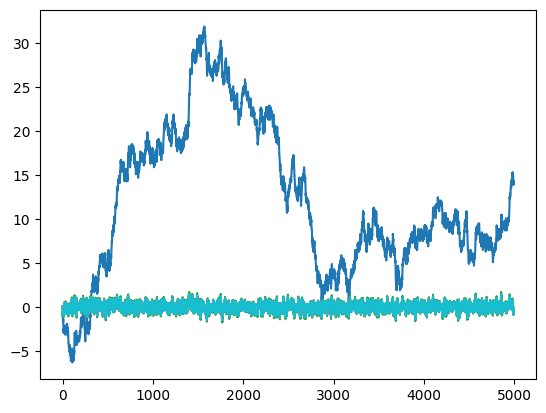

In [38]:
plt.plot(resid[:,0:20])

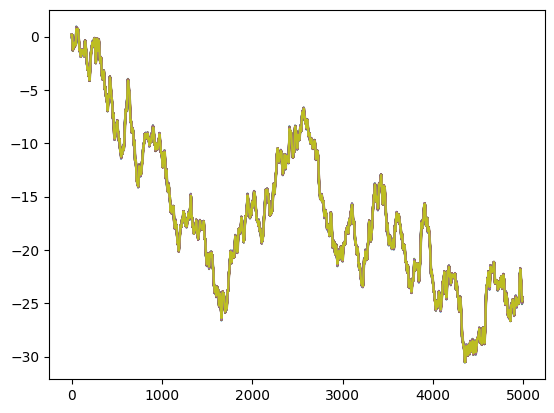

In [21]:
plt.plot(convolved_output[:, 1:50])

In [2]:
import numpy as np

def find_equal_arrays(array_list):
    """
    Finds and groups NumPy arrays in a list that are equal to each other.

    Args:
        array_list (list of numpy arrays): A list containing NumPy arrays.

    Returns:
        list of lists: A list where each inner list contains the *indices* of arrays
                       in the input `array_list` that are equal to each other.  
                       Arrays are considered equal if all their elements are equal.

                       For example, if array_list = [array1, array2, array3]
                       and array1 and array3 are equal, the function might return:
                       [[0, 2], [1]]  (array1 and array3 are at indices 0 and 2, array2 at 1)

                       or
                       [[1], [0, 2]]

                       The order of the inner lists and the order of indices within the inner
                       lists is not guaranteed.
    """

    equal_groups = []
    remaining_indices = list(range(len(array_list)))  # Indices to process

    while remaining_indices:
        first_index = remaining_indices.pop(0)  # Take the first unprocessed array
        equal_group = [first_index]
        first_array = array_list[first_index]

        # Compare to all remaining unprocessed arrays
        indices_to_remove = []
        for i in remaining_indices:
            other_array = array_list[i]
            if np.array_equal(first_array, other_array):
                equal_group.append(i)
                indices_to_remove.append(i)

        # Remove the matched indices from remaining_indices (in reverse order to avoid shifting issues)
        for i in sorted(indices_to_remove, reverse=True):
            remaining_indices.remove(i)

        equal_groups.append(equal_group)

    return equal_groups


# Example Usage:
array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])
array3 = np.array([1, 2, 3])  # Equal to array1
array4 = np.array([7, 8, 9])
array5 = np.array([4, 5, 6])  # Equal to array2
array6 = np.array([1, 2, 3])  # Equal to array1 and array3

my_list = [array1, array2, array3, array4, array5, array6]
equality_groups = find_equal_arrays(my_list)
print(f"Arrays equal to each other (grouped by indices): {equality_groups}")


array7 = np.array([1, 1, 1])
array8 = np.array([1, 1, 1])
array9 = np.array([2, 2, 2])

my_list2 = [array7, array8, array9]
equality_groups2 = find_equal_arrays(my_list2)
print(f"Arrays equal to each other (grouped by indices) 2: {equality_groups2}")

Arrays equal to each other (grouped by indices): [[0, 2, 5], [1, 4], [3]]
Arrays equal to each other (grouped by indices) 2: [[0, 1], [2]]


In [6]:
convolved_output.numpy().shape

(9991, 60025)

In [6]:
result = subtract_2d_from_1d(time_series[9:], convolved_output[:, 1:50].numpy())
plt.plot(result)

ValueError: Arrays must have the same length along the last dimension

(4991, 1)
Shape of result is: (4991, 50)


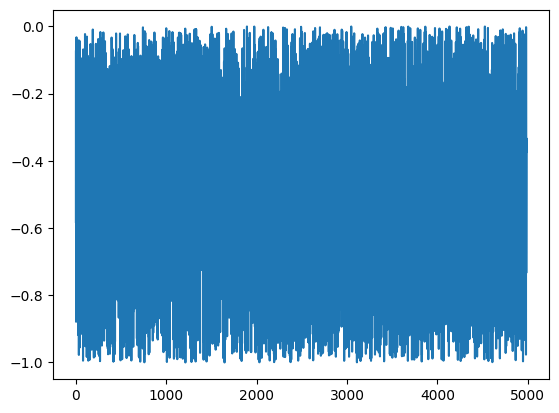

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def subtract_2d_from_1d(arr_1d, arr_2d):
    """
    Subtracts a 1D array from a 2D array element-wise, leveraging broadcasting.

    Args:
        arr_1d: A 1D numpy array of length n.
        arr_2d: A 2D numpy array of shape (m, n) or (n, m).  The 'n' dimension
                must match the length of arr_1d.

    Returns:
        A 2D numpy array where arr_1d has been subtracted element-wise
        from each matching element in arr_2d.
    """

    # Check if arr_1d can be broadcast to arr_2d
    if arr_1d.shape[0] != arr_2d.shape[0] and arr_1d.shape[0] != arr_2d.shape[1]:
        raise ValueError("Arrays are not compatible for broadcasting.")

    # Handle the case where arr_1d needs to be applied along axis 1
    if arr_1d.shape[0] == arr_2d.shape[1]:
      result = arr_2d - arr_1d
    # Handle the case where arr_1d needs to be applied along axis 0
    else:
      result = arr_2d - arr_1d[:, np.newaxis] # add axis=1 for broadcasting
      print(arr_1d[:, np.newaxis].shape)

    return result

# Example Usage:
time_series = np.random.rand(5000)

#Correct, but likely *not* the desired behaviour, it needs to be (50, 50) for elementwise subtraction
result = subtract_2d_from_1d(time_series[9:], convolved_output[:, 0:50]) # Shape of result is (9991, 50)

print("Shape of result is: " + str(result.shape))
# Plotting will now work (select a row)
plt.plot(result[:, 0])
plt.show()

In [17]:
print(time_series[9:].shape, convolved_output[:, 0:50].shape)

(4991,) (4991, 50)
